# Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

# Análisis exploratorio

In [2]:
data = pd.read_csv('Data/ds_index_next.csv')
data.shape

(87438, 43)

In [3]:
data.head()

,YEAR,CODE,VQ_MARKET_CAP,CSR__ROE,VR__EV_TO_EBIT,CSR__ROC_JOEL_GREENBLATT,CSR__OPERATING_MARGIN,VQ__PIOTROSKI_F_SCORE,VR__PS_RATIO,VR__PB_RATIO,...,RISK,INDUSTRY01,INDUSTRY02,RETURNS_NEXT,RETURNS_CAT,RETURNS_NEXT_CAT,INDEX_RETURNS,INDEX_RETURNS_NEXT,RETURNS_vs_INDEX,RETURNS_vs_INDEX_NEXT
0,2014,ETE,31002.7009,72.22,28.98,8.00,5.10,7,0.56,46.73,...,3.472920,NaN,NaN,-0.512675,POSITIVE,NEGATIVE,0.123866,-0.006928,WINS,LOSES
1,2010,ETE,8712.4952,317.83,24.53,9.21,15.92,5,1.33,72.37,...,0.730981,NaN,NaN,0.045082,POSITIVE,POSITIVE,0.110019,-0.011220,WINS,WINS
2,2015,ETE,14384.6808,0.00,28.67,5.90,7.28,7,0.41,0.00,...,6.159618,NaN,NaN,0.897959,NEGATIVE,POSITIVE,-0.006928,0.112374,LOSES,WINS
3,2012,ETE,12732.3534,27.89,19.82,11.46,8.02,5,0.73,6.03,...,0.649843,NaN,NaN,0.657980,POSITIVE,POSITIVE,0.116776,0.263905,WINS,WINS
4,2007,ETE,8191.2308,2122.84,25.13,14.74,11.92,5,1.16,0.00,...,0.797453,NaN,NaN,-0.502987,POSITIVE,NEGATIVE,0.036538,-0.375847,WINS,LOSES


## Preprocesamiento de variables

In [4]:
gb = data[['YEAR', 'CODE', 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT', 'RETURNS_NEXT']]
gb.head()

,YEAR,CODE,CSR__ROC_JOEL_GREENBLATT,VR__EV_TO_EBIT,RETURNS_NEXT
0,2014,ETE,8.00,28.98,-0.512675
1,2010,ETE,9.21,24.53,0.045082
2,2015,ETE,5.90,28.67,0.897959
3,2012,ETE,11.46,19.82,0.657980
4,2007,ETE,14.74,25.13,-0.502987


In [5]:
gb.query('YEAR > 1990 & YEAR < 2016', inplace=True)
gb.dropna(inplace=True)
gb['CSR__ROC_JOEL_GREENBLATT_RANKING'] = gb.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb['VR__EV_TO_EBIT_RANKING'] = gb.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb['RETURNS_NEXT_RANKING'] = gb.groupby(by=['YEAR'])['RETURNS_NEXT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb.head()

,YEAR,CODE,CSR__ROC_JOEL_GREENBLATT,VR__EV_TO_EBIT,RETURNS_NEXT,CSR__ROC_JOEL_GREENBLATT_RANKING,VR__EV_TO_EBIT_RANKING,RETURNS_NEXT_RANKING
0,2014,ETE,8.00,28.98,-0.512675,2315.0,516.0,3934.0
1,2010,ETE,9.21,24.53,0.045082,1697.0,415.0,901.0
2,2015,ETE,5.90,28.67,0.897959,2338.0,516.0,389.0
3,2012,ETE,11.46,19.82,0.657980,1712.0,525.0,651.0
4,2007,ETE,14.74,25.13,-0.502987,1001.0,291.0,1065.0


# Aproximación 1

In [6]:
gb1 = gb[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING', 'RETURNS_NEXT_RANKING']]

## División y escalado de datos

In [7]:
X1 = gb1.drop(['RETURNS_NEXT_RANKING'], axis=1)
y1 = gb1['RETURNS_NEXT_RANKING']

feature_names = X1.columns

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, shuffle= True, random_state=10, test_size=0.20)

## Algoritmos

### Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(X1_train, y1_train)

y1_pred_train = lr.predict(X1_train)
y1_pred_test = lr.predict(X1_test)

mseTrainModelLR1 = mean_squared_error(y1_train, y1_pred_train)
mseTestModelLR1 = mean_squared_error(y1_test, y1_pred_test)

print('MSE Modelo Lineal Simple (train): %0.7g' % mseTrainModelLR1)
print('MSE Modelo Lineal Simple (test) : %0.7g' % mseTestModelLR1)
print('R^2 (train): {:.4f}'.format(lr.score(X1_train, y1_train)))
print('R^2 (test): {:.4f}'.format(lr.score(X1_test, y1_test)))

print('Coefficients:')
w = lr.coef_
for f, wi in zip(feature_names, w):
    print(f, wi)
print('Intercept:', lr.intercept_)

MSE Modelo Lineal Simple (train): 999489.3
MSE Modelo Lineal Simple (test) : 1000655
R^2 (train): 0.2283
R^2 (test): 0.2338
Coefficients:
CSR__ROC_JOEL_GREENBLATT_RANKING 0.3400967286036717
VR__EV_TO_EBIT_RANKING 0.28812920387373175
Intercept: 678.0111108846475


**Save DATA**

In [9]:
save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
             'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
             'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))

In [10]:
result = save[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
result.dropna(inplace=True)
result['prediction'] = lr.predict(result)

In [11]:
save = pd.concat([save, result['prediction']], axis=1, join='inner')
save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
    .transform(lambda x: x.rank(method='dense', ascending=True))
save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
           'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
save.to_csv('Results/metrics_LR_GB.csv', index=False)

### Decision Tree

best mean cross-validation score: -950312.280
best parameters: {'max_depth': 5}


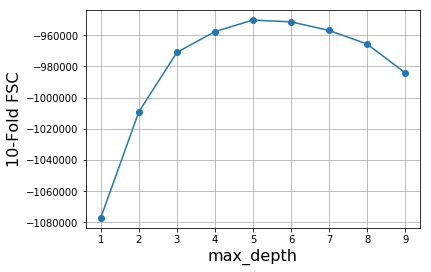

In [12]:
maxDepth = range(1, 10)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeRegressor(random_state = 0),
                    scoring = 'neg_mean_squared_error',
                    param_grid = param_grid,
                    cv = 10)

grid.fit(X1_train, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
plt.plot(maxDepth, scores, '-o')
plt.xlabel('max_depth', fontsize = 16)
plt.ylabel('10-Fold FSC', fontsize = 16)
plt.grid()
plt.show()

In [13]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeRegressor(random_state = 0,
                             max_depth = depthOpt).fit(X1_train, y1_train)
y1trainDecisionTree = tree.predict(X1_train)
y1testDecisionTree  = tree.predict(X1_test)

mseTrainModelDecisionTree1 = mean_squared_error(y1_train, y1trainDecisionTree)
mseTestModelDecisionTree1 = mean_squared_error(y1_test, y1testDecisionTree)

print('MSE Modelo Decision Tree (train): %0.3g' % mseTrainModelDecisionTree1)
print('MSE Modelo Decision Tree (test) : %0.3g' % mseTestModelDecisionTree1)
print("R^2 (train): {:.4f}".format(tree.score(X1_train, y1_train)))
print("R^2 (test): {:.4f}".format(tree.score(X1_test, y1_test)))

MSE Modelo Decision Tree (train): 9.4e+05
MSE Modelo Decision Tree (test) : 9.5e+05
R^2 (train): 0.2746
R^2 (test): 0.2725


**Save DATA**

In [14]:
save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
             'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
             'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))

In [15]:
result = save[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
result.dropna(inplace=True)
result['prediction'] = tree.predict(result)

In [16]:
save = pd.concat([save, result['prediction']], axis=1, join='inner')
save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
    .transform(lambda x: x.rank(method='dense', ascending=True))
save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
           'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
save.to_csv('Results/metrics_DT_GB.csv', index=False)

### Random Forest

best mean cross-validation score: -940844.059
best parameters: {'max_depth': 8}


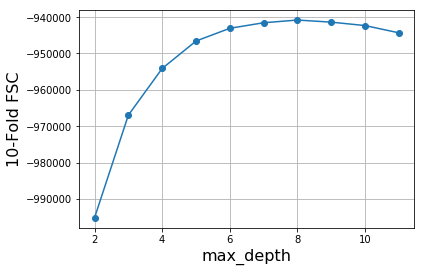

In [17]:
maxDepth   = range(2, 12)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state = 0, n_estimators = 200, max_features = 'sqrt'),
                    scoring = 'neg_mean_squared_error', 
                    param_grid = param_grid, 
                    cv = 10,
                    n_jobs = -1)

grid.fit(X1_train, y1_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
plt.plot(maxDepth, scores, '-o')
plt.xlabel('max_depth', fontsize = 16)
plt.ylabel('10-Fold FSC', fontsize = 16)
plt.grid()
plt.show()

In [18]:
depthOpt = grid.best_params_['max_depth']

rf = RandomForestRegressor(random_state = 0,
                           max_depth = depthOpt,
                           n_estimators = 200,
                           max_features = 'sqrt').fit(X1_train, y1_train)
y1trainRandomForest = rf.predict(X1_train)
y1testRandomForest  = rf.predict(X1_test)

mseTrainModelRandomForest1 = mean_squared_error(y1_train, y1trainRandomForest)
mseTestModelRandomForest1 = mean_squared_error(y1_test, y1testRandomForest)

print('MSE Modelo Random Forest (train): %0.3g' % mseTrainModelRandomForest1)
print('MSE Modelo Random Forest (test) : %0.3g' % mseTestModelRandomForest1)
print("R^2 (train): {:.4f}".format(rf.score(X1_train, y1_train)))
print("R^2 (test): {:.4f}".format(rf.score(X1_test, y1_test)))

MSE Modelo Random Forest (train): 8.99e+05
MSE Modelo Random Forest (test) : 9.36e+05
R^2 (train): 0.3060
R^2 (test): 0.2831


**Save DATA**

In [19]:
save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
             'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
             'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))

In [20]:
result = save[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
result.dropna(inplace=True)
result['prediction'] = rf.predict(result)

In [21]:
save = pd.concat([save, result['prediction']], axis=1, join='inner')
save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
    .transform(lambda x: x.rank(method='dense', ascending=True))
save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
           'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
save.to_csv('Results/metrics_RF_GB.csv', index=False)

### XGBoost

In [22]:
xg_reg = xgb.XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bytree=0.3, gamma=0, learning_rate=0.15, max_delta_step=0,
                          max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
                          n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                          silent=True, subsample=1)

In [23]:
xg_reg.fit(X1_train, y1_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
y1_pred_train = xg_reg.predict(X1_train)
y1_pred_test = xg_reg.predict(X1_test)

mseTrainModelLR1 = mean_squared_error(y1_train, y1_pred_train)
mseTestModelLR1 = mean_squared_error(y1_test, y1_pred_test)

print('MSE Modelo Lineal Simple (train): %0.7g' % mseTrainModelLR1)
print('MSE Modelo Lineal Simple (test) : %0.7g' % mseTestModelLR1)
print('R^2 (train): {:.4f}'.format(xg_reg.score(X1_train, y1_train)))
print('R^2 (test): {:.4f}'.format(xg_reg.score(X1_test, y1_test)))

MSE Modelo Lineal Simple (train): 965677.5
MSE Modelo Lineal Simple (test) : 991632.4
R^2 (train): 0.2544
R^2 (test): 0.2407


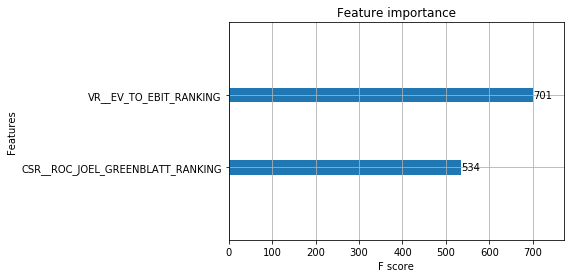

In [25]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

**Save DATA**

In [26]:
save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
             'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
             'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))

In [27]:
result = save[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
result.dropna(inplace=True)
result['prediction'] = xg_reg.predict(result)

In [28]:
save = pd.concat([save, result['prediction']], axis=1, join='inner')
save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
    .transform(lambda x: x.rank(method='dense', ascending=True))
save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
           'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
save.to_csv('Results/metrics_XGB_GB.csv', index=False)

### XGBoost k-fold

In [29]:
param_dist = {'objective': 'reg:linear',
              'max_depth': 5,
              'colsample_bytree': 0.7,
              'alpha': 10,
              'learning_rate': 0.15,
              'silent': 1}

n_folds = 3
early_stopping = 10

xg_train = xgb.DMatrix(X1_train, label=y1_train)

cv = xgb.cv(param_dist, xg_train, 500, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-rmse:1676.49+4.21978	test-rmse:1676.9+10.2835
[1]	train-rmse:1521.13+3.28586	test-rmse:1521.94+10.596
[2]	train-rmse:1397.91+2.52777	test-rmse:1399.34+10.7313
[3]	train-rmse:1301.55+1.98452	test-rmse:1303.49+10.6133
[4]	train-rmse:1225.26+3.19132	test-rmse:1227.66+8.7058
[5]	train-rmse:1167.01+4.20183	test-rmse:1169.87+7.1376
[6]	train-rmse:1121.27+2.91049	test-rmse:1124.79+6.65732
[7]	train-rmse:1087.87+3.40817	test-rmse:1092.04+5.67788
[8]	train-rmse:1063.04+3.83824	test-rmse:1067.78+4.91769
[9]	train-rmse:1044.48+4.10202	test-rmse:1049.84+4.71432
[10]	train-rmse:1030.66+4.48085	test-rmse:1036.57+4.58912
[11]	train-rmse:1019.25+3.0958	test-rmse:1025.76+4.24278
[12]	train-rmse:1011.75+3.29058	test-rmse:1018.73+4.23627
[13]	train-rmse:1006.19+3.38626	test-rmse:1013.71+4.36762
[14]	train-rmse:1001.18+2.28814	test-rmse:1009.24+3.9975
[15]	train-rmse:998.023+2.36984	test-rmse:1006.37+4.31068
[16]	train-rmse:995.611+2.54544	test-rmse:1004.51+4.44802
[17]	train-rmse:993.661+2.8253

In [30]:
xg_reg_fold = xgb.train(params=param_dist, dtrain=xg_train, num_boost_round=cv.shape[0])

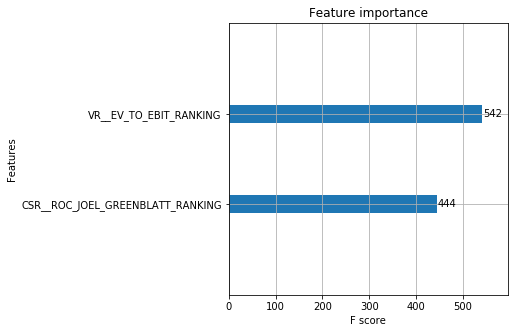

In [31]:
xgb.plot_importance(xg_reg_fold)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

**Save DATA**

In [32]:
save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
             'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
             'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))

In [33]:
result = save[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
result.dropna(inplace=True)
result_xg = xgb.DMatrix(result)
result['prediction'] = xg_reg_fold.predict(result_xg)

In [34]:
save = pd.concat([save, result['prediction']], axis=1, join='inner')
save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
    .transform(lambda x: x.rank(method='dense', ascending=True))
save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
           'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
save.to_csv('Results/metrics_XGB_KF_GB.csv', index=False)

# Aproximación 2

## Linear Regression

In [35]:
final = pd.DataFrame()
for x in range(2000, 2018):
    gb2 = gb.query('YEAR >= @x-10 & YEAR <= @x-1')[['CSR__ROC_JOEL_GREENBLATT_RANKING',
                                                    'VR__EV_TO_EBIT_RANKING',
                                                    'RETURNS_NEXT_RANKING']]
    X2 = gb2.drop(['RETURNS_NEXT_RANKING'], axis=1)
    y2 = gb2['RETURNS_NEXT_RANKING']

    feature_names = X2.columns

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle= True, random_state=10, test_size=0.25)
    
    lr = LinearRegression()
    lr.fit(X2_train, y2_train)

    save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
                 'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
                 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
    save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    
    result = save.query('YEAR == @x')[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
    result.dropna(inplace=True)
    result['prediction'] = lr.predict(result)
    
    save = pd.concat([save, result['prediction']], axis=1, join='inner')
    save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))
    save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
               'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
    save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                    'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
    save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
    
    final = final.append(save)

final.to_csv('Results/metrics_LR_W10_GB.csv', index=False)

## Random Forest

In [36]:
final = pd.DataFrame()
for x in range(2000, 2018):
    gb2 = gb.query('YEAR >= @x-10 & YEAR <= @x-1')[['CSR__ROC_JOEL_GREENBLATT_RANKING',
                                                    'VR__EV_TO_EBIT_RANKING',
                                                    'RETURNS_NEXT_RANKING']]
    X2 = gb2.drop(['RETURNS_NEXT_RANKING'], axis=1)
    y2 = gb2['RETURNS_NEXT_RANKING']

    feature_names = X2.columns

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle= True, random_state=10, test_size=0.25)
    
    maxDepth   = range(2, 12)
    param_grid = {'max_depth': maxDepth}

    grid = GridSearchCV(RandomForestRegressor(random_state = 0, n_estimators = 200, max_features = 'sqrt'),
                        scoring = 'neg_mean_squared_error', 
                        param_grid = param_grid, 
                        cv = 10,
                        n_jobs = -1)

    grid.fit(X2_train, y2_train)
    
    depthOpt = grid.best_params_['max_depth']

    rf = RandomForestRegressor(random_state = 0,
                               max_depth = depthOpt,
                               n_estimators = 200,
                               max_features = 'sqrt').fit(X2_train, y2_train)
    
    save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
                 'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
                 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
    save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    
    result = save.query('YEAR == @x')[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
    result.dropna(inplace=True)
    result['prediction'] = rf.predict(result)
    
    save = pd.concat([save, result['prediction']], axis=1, join='inner')
    save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))
    save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
               'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
    save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                    'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
    save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
    
    final = final.append(save)
final.to_csv('Results/metrics_RF_W10_GB.csv', index=False)

# Aproximación 3

In [37]:
final = pd.DataFrame()
for x in range(2000, 2018):
    gb3 = gb.query('YEAR >= @x-5 & YEAR <= @x-1')[['CSR__ROC_JOEL_GREENBLATT_RANKING',
                                                   'VR__EV_TO_EBIT_RANKING',
                                                   'RETURNS_NEXT_RANKING']]
    X2 = gb3.drop(['RETURNS_NEXT_RANKING'], axis=1)
    y2 = gb3['RETURNS_NEXT_RANKING']

    feature_names = X2.columns

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle= True, random_state=10, test_size=0.25)
    
    lr = LinearRegression()
    lr.fit(X2_train, y2_train)

    save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
                 'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
                 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
    save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    
    result = save.query('YEAR == @x')[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
    result.dropna(inplace=True)
    result['prediction'] = lr.predict(result)
    
    save = pd.concat([save, result['prediction']], axis=1, join='inner')
    save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))
    save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
               'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
    save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                    'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
    save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
    
    final = final.append(save)

final.to_csv('Results/metrics_LR_W5_GB.csv', index=False)